In [39]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pathlib import Path

import cv2

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.autograd import set_detect_anomaly

from shutil import copyfile
import zipfile

In [ ]:
!unzip /content/drive/MyDrive/set-lipstick-original.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: set-lipstick-original/mask/mask00023595.png  
  inflating: set-lipstick-original/mask/mask00023596.png  
  inflating: set-lipstick-original/mask/mask00023597.png  
  inflating: set-lipstick-original/mask/mask00023598.png  
  inflating: set-lipstick-original/mask/mask00023599.png  
  inflating: set-lipstick-original/mask/mask00023600.png  
  inflating: set-lipstick-original/mask/mask00023601.png  
  inflating: set-lipstick-original/mask/mask00023602.png  
  inflating: set-lipstick-original/mask/mask00023603.png  
  inflating: set-lipstick-original/mask/mask00023604.png  
  inflating: set-lipstick-original/mask/mask00023605.png  
  inflating: set-lipstick-original/mask/mask00023606.png  
  inflating: set-lipstick-original/mask/mask00023607.png  
  inflating: set-lipstick-original/mask/mask00023608.png  
  inflating: set-lipstick-original/mask/mask00023609.png  
  inflating: set-lipstick-original/mask/mask000

In [ ]:
lipsRGB = []
lipsSeg = []
for root, dirs, files in os.walk('/content/set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            lipsRGB.append(f)
        elif 'mask' in f:
            lipsSeg.append(f)
        else:
            break

In [ ]:
data_dict = {'lipsRGB': lipsRGB, 'lipsSeg': lipsSeg}
min_length = min(len(data_dict['lipsRGB']), len(data_dict['lipsSeg']))
min_length

28540

In [ ]:
mask = pd.DataFrame(lipsSeg, columns = ['lipsSeg'])
mask['ind'] = mask['lipsSeg'].replace(regex = True, to_replace = '/content/set-lipstick-original/mask/mask' , value = '').replace(regex = True, to_replace = '\D' , value = '')
mask.set_index('ind')

,lipsSeg
ind,
00014304,/content/set-lipstick-original/mask/mask000143...
00017171,/content/set-lipstick-original/mask/mask000171...
00012148,/content/set-lipstick-original/mask/mask000121...
00019490,/content/set-lipstick-original/mask/mask000194...
00024483,/content/set-lipstick-original/mask/mask000244...
...,...
00000722,/content/set-lipstick-original/mask/mask000007...
00011547,/content/set-lipstick-original/mask/mask000115...
00020420,/content/set-lipstick-original/mask/mask000204...


In [ ]:
lips = pd.DataFrame(lipsRGB, columns = ['lipsRGB'])
lips['ind'] = lips['lipsRGB'].replace(regex = True, to_replace = '/content/set-lipstick-original/720p/image' , value = '').replace(regex = True, to_replace = '\D' , value = '')
lips.set_index('ind')

,lipsRGB
ind,
00002325,/content/set-lipstick-original/720p/image00002...
00006831,/content/set-lipstick-original/720p/image00006...
00027831,/content/set-lipstick-original/720p/image00027...
00028549,/content/set-lipstick-original/720p/image00028...
00000250,/content/set-lipstick-original/720p/image00000...
...,...
00008954,/content/set-lipstick-original/720p/image00008...
00004776,/content/set-lipstick-original/720p/image00004...
00027288,/content/set-lipstick-original/720p/image00027...


In [ ]:
df = lips.merge(mask).drop(['ind'], axis = 1)
# Отсортируем  датафрейм по значениям
df.sort_values(by='lipsRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                             lipsRGB                                            lipsSeg
0  /content/set-lipstick-original/720p/image00000...  /content/set-lipstick-original/mask/mask000000...
1  /content/set-lipstick-original/720p/image00000...  /content/set-lipstick-original/mask/mask000000...
2  /content/set-lipstick-original/720p/image00000...  /content/set-lipstick-original/mask/mask000000...
3  /content/set-lipstick-original/720p/image00000...  /content/set-lipstick-original/mask/mask000000...
4  /content/set-lipstick-original/720p/image00000...  /content/set-lipstick-original/mask/mask000000...


In [ ]:
df = df[:2500]

In [ ]:
def img_to_bin(read_path, write_path):
    img = cv2.cvtColor(cv2.imread(str(read_path)), cv2.COLOR_BGR2RGB)
    height, width, channels = img.shape
    img_binary = np.zeros((height,width,1))
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale
    (thresh, img_binary) = cv2.threshold(img_grayscale, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_binary = cv2.bitwise_not(img_binary) #invert img
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, img_binary)
    return new_path

In [ ]:
new_paths = []
bin_path = Path('/content/bin_mask_inverted')
for index, row in df.iterrows():
    new_path = img_to_bin(Path(row['lipsSeg']), bin_path)
    new_paths.append(new_path)
df['lipsSeg_bin'] = new_paths

In [ ]:
df.head()

,lipsRGB,lipsSeg,lipsSeg_bin
0,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000001.png
1,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000002.png
2,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000003.png
3,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000004.png
4,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000005.png


In [ ]:
df.to_csv('./paths_inverted.csv', index = False)
df = pd.read_csv("./paths_inverted.csv")
df.head()

,lipsRGB,lipsSeg,lipsSeg_bin
0,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000001.png
1,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000002.png
2,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000003.png
3,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000004.png
4,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...,/content/bin_mask_inverted/mask00000005.png


255 1.0


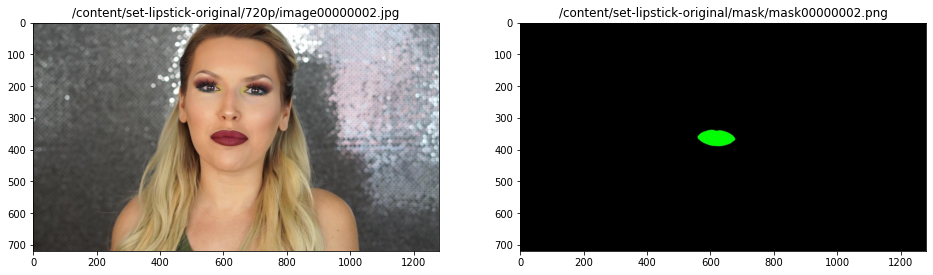

In [ ]:
idx = 1

imgArray = plt.imread(df.loc[idx]['lipsRGB'])
maskArray = plt.imread(df.loc[idx]['lipsSeg'])

print(imgArray.max(), maskArray.max()) 

plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(imgArray)
plt.title(df.loc[idx]['lipsRGB'])

plt.subplot(1, 2, 2)
plt.imshow(maskArray)
plt.title(df.loc[idx]['lipsSeg'])

plt.show()

In [ ]:
labels = ['lips']

[  0 255]


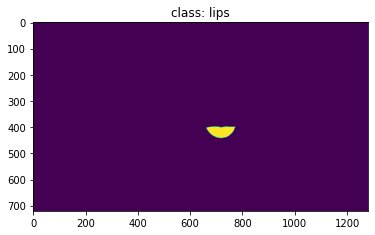

In [ ]:
for i in range(1):
    mask = plt.imread('/content/bin_mask_inverted/mask00000001.png')*255
    mask = np.where(mask == i, 255, 0)
#     mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [ ]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,2]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
        # convert str names to class values on masks
        # Конвертируем стринговые имена в значения класса на маске
        self.class_values = [labels.index(cls) for cls in labels]
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256, 256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
        mask = np.asarray(plt.imread(self.label_arr[index]))*255

        # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')

        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)

#         mask = mask.view(mask.shape[0], mask.shape[1], 1)
#         mask = torch.FloatTensor(mask[None,].type(torch.float32))
#         print(mask.size())
        # Размерность каналов на передний план
        mask = mask.permute(2, 0, 1)

        
        # делаем ресайз маски на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        # unsqueeze - меняет размерность img c (256, 256, 3) -> (1, 256, 256, 3),
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        mask=mask.squeeze(0)
#         print(mask.size())

        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [ ]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [ ]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=5,shuffle=False)

In [ ]:
sample = iter(train_data_loader).next()

In [ ]:
sample[0].size()

torch.Size([8, 3, 256, 256])

In [ ]:
sample[1].size()

torch.Size([8, 1, 256, 256])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 245kB 9.1MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=fb54a9739701c306b902c57c08d0542d919b275b5823f283faa628488ca20c63
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=14ee8c3cd5aa60dcdc3c96b0e1a3062930639548afe5e70f5afa39a619dbf1dd
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [38]:
import segmentation_models_pytorch as smp

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', encoder_weights = 'imagenet', classes=1, activation='sigmoid').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['fscore']:
#         max_score = valid_logs['fscore']
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 150/150 [00:46<00:00,  3.20it/s, dice_loss - 0.05733, iou_score - 0.9105]
Model saved!

Epoch: 1
valid: 100%|██████████| 150/150 [00:46<00:00,  3.21it/s, dice_loss - 0.05022, iou_score - 0.9115]
Model saved!

Epoch: 2
valid: 100%|██████████| 150/150 [00:46<00:00,  3.23it/s, dice_loss - 0.02951, iou_score - 0.9472]
Model saved!

Epoch: 3
valid: 100%|██████████| 150/150 [00:46<00:00,  3.26it/s, dice_loss - 0.02684, iou_score - 0.951]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 150/150 [00:47<00:00,  3.15it/s, dice_loss - 0.0255, iou_score - 0.9543]
Model saved!


In [40]:
valid_logs

{'dice_loss': 0.025501845524267548, 'iou_score': 0.9543258724738393}

In [41]:
best_model = torch.load('./best_smp_model.pth')

In [42]:
images, labels = iter(train_data_loader).next()
labels[0].size()

torch.Size([1, 256, 256])

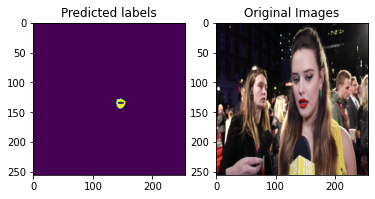

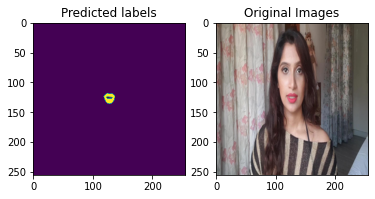

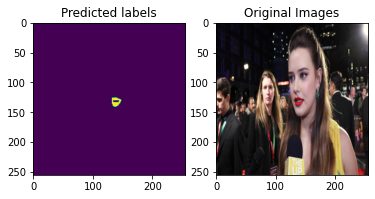

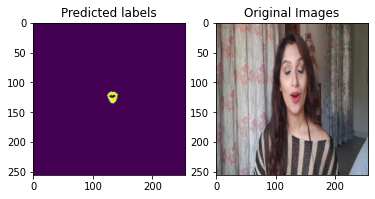

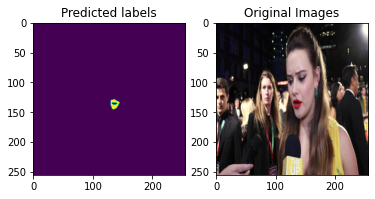

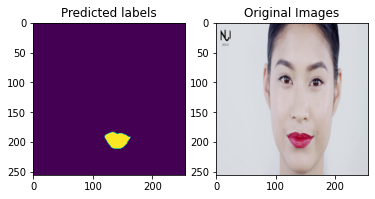

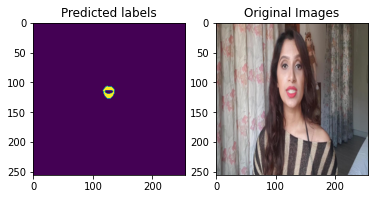

In [63]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = best_model(images)
    f, axarr = plt.subplots(1,2)

    for j in range(0,5):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Predicted labels')

        original = images[j].cpu().permute(1, 2, 0)
        axarr[1].imshow(original)
        axarr[1].set_title('Original Images')
        plt.show()
    if i>5:
        break